<b>Dive in and explore the data set. Include your code and visuals from this process in your final wrap up. While doing this, look for something that provokes a question; specifically one that can be answered with an experiment. Using the data set, propose and outline an experiment plan consisting of: analysis of experimental hypothesis, rollout plan showing how to implement and rollout the experiment, and evaluation plan showing what constitutes success in this experiment.</b>

The dataset that I am using is from Kiva loans, an organization that coordinates with borrowers and lenders to facilitate money lending. As with all money lending, there are bound to be loans that are successful (funded) and others that are not (unfunded). I want to see if there is anything within the data that I can use to run an A/B Testing on.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

In [2]:
loans = pd.read_csv('../Datasets/kiva_loans.csv',
                   usecols=[0, 1, 2, 3, 4, 5, 9, 10, 11, 12])

In [3]:
sns.set_style('white')
loans.head()

,id,funded_amount,loan_amount,activity,sector,use,term_in_months,lender_count,repayment_interval,date
0,1080153,5000,5000,Food Production/Sales,Food,hire more staff to keep up with the volume of ...,30,261,monthly,1/2/2014
1,653415,4000,4000,Cosmetics Sales,Retail,to purchase more inventory to sell,26,93,monthly,1/2/2014
2,1080154,10000,10000,Food Production/Sales,Food,outfit my new kitchen so that I can expand my ...,36,280,monthly,1/2/2014
3,653761,5000,5000,Farming,Agriculture,to purchase a tractor,32,158,monthly,1/3/2014
4,653803,5450,5450,Services,Services,to market her new business.,32,164,monthly,1/3/2014


In [4]:
#add columns funded and count
loans['funded'] = np.where(loans['funded_amount'] == loans['loan_amount'], 1, 0)
loans['count'] = 1

# check number of funded and unfunded loans
funded_loans = loans[loans['funded']==1]
unfunded_loans = loans[loans['funded']==0]
print('Number of funded loans: ', len(funded_loans))
print('Number of unfunded loans: ', len(unfunded_loans))

Number of funded loans:  3892
Number of unfunded loans:  2201


In [5]:
#creating a new dataframe to check funding status by sector
loans_sector = loans.groupby(['sector', 'funded']).count()['count'].reset_index()

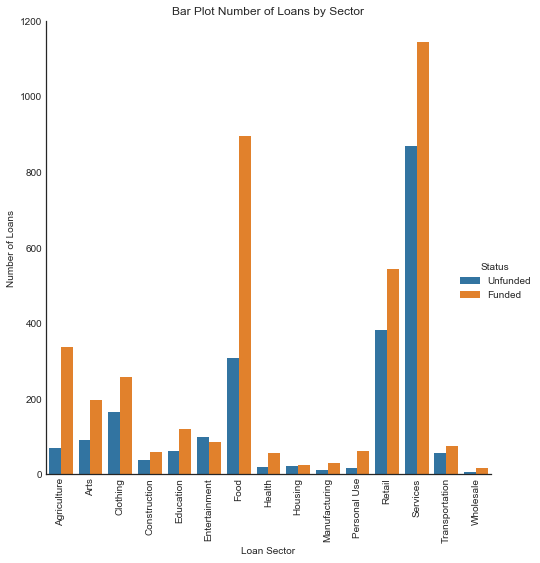

In [6]:
#stacked bar chart, sorted
g=sns.factorplot(x='sector', y='count', hue='funded', data=loans_sector, size=7, kind='bar')
g.set_xlabels('Loan Sector')
g.set_ylabels('Number of Loans')
plt.title('Bar Plot Number of Loans by Sector')
g.set_xticklabels(rotation=90)

# title
g._legend.set_title('Status')
# replace labels
new_labels = ['Unfunded', 'Funded']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
plt.show()

In [7]:
#average mean of funded v fund of food and agriculture
funded_loans = loans_sector[loans_sector['funded']==1].groupby('sector').sum()['count']
total_loans = loans_sector.groupby('sector').sum()['count']

proportion_of_funded_loans = funded_loans/total_loans
print('The mean of funded loans: ', proportion_of_funded_loans)

The mean of funded loans:  sector
Agriculture       0.831266
Arts              0.682927
Clothing          0.611905
Construction      0.610526
Education         0.662921
Entertainment     0.469945
Food              0.744380
Health            0.746667
Housing           0.543478
Manufacturing     0.743590
Personal Use      0.782051
Retail            0.588108
Services          0.568657
Transportation    0.568182
Wholesale         0.714286
Name: count, dtype: float64


Based on the above graphs and data, there are certain sectors that are more effective at getting loans funded. Perhaps if there are more loans from the food/agriculture sector, the number of total accepted loans will go up. While several other sectors also have a high loan funding rate (health, manufacturing, personal use, and wholesale), there are not enough data to determine if it is due to a low number of loans in those sectors or if those sectors actually has a higher chance of being funded.

In [8]:
food_and_agriculture_loans = loans.set_index('sector').loc[['Food', 'Agriculture']]
food_and_agriculture_loans.groupby('funded').mean()['term_in_months']

funded
0    27.301333
1    29.510171
Name: term_in_months, dtype: float64

For food and agriculture, it appears that the longer termed loans are more likely to be funded. If we raise the minimum loan term, will more loans be funded?

# RFC

While Kiva is a non profit organization, they must still cover operating costs and other expenses to further grow their organization. Besides receiving donations, the only other option as a loan operating company to generate money, is to have the loans be successfully funded. There are many approaches to doing this: how the way the loans are advertised to the lenders, increasing the number of total available lenders, and optimizing how the loans are distributed. Increasing the profitability of Kiva is a good thing. If there are more successful loans being issued out, then the percentage that Kiva charges per successful loan can decrease, leading to more money available for the lenders.

## Based on the data of loans provided by Kiva, Kiva should raise the minimum number of payment term months by 2 months to improve the funding rate of loans

To confirm that the sample data doesn't have any big discrepancy, an A/A testing is run before the A/B testing

In [9]:
sample_size = int(len(food_and_agriculture_loans) / 2)
sample1 = food_and_agriculture_loans.sample(n=sample_size)

#find common id in sample1 and population of food and agriculture and select non common ids for sample2 
common = food_and_agriculture_loans.merge(sample1,on='id')
sample2 = food_and_agriculture_loans[(~food_and_agriculture_loans.id.isin(common.id))]

print('sample1 mean: ', sample1.groupby('funded').mean()['term_in_months'])
print('sample2 mean: ', sample2.groupby('funded').mean()['term_in_months'])
print(stats.ttest_ind(sample1.funded, sample2.funded))

sample1 mean:  funded
0    27.195000
1    29.669435
Name: term_in_months, dtype: float64
sample2 mean:  funded
0    27.422857
1    29.357257
Name: term_in_months, dtype: float64
Ttest_indResult(statistic=-1.4749400414994733, pvalue=0.14042515691491264)


The A/A testing appears to show that sample of food and agriculture sectors are identical to one another, and that we can proceed with the A/B testing.

Kiwa should increase the minimum payment terms by 2 months for a duration of three months to increase the rate of funded loans. After the three months are over, compare the number of funded loans in agriculture and food sectors. If the number of funded loans are higher by 5%, consider the experiment a success and keep the payment terms indefinitely. If the average of funded loans are similar to pre experiment average, continue the experiment for another 3 months. If the average of funded loans is lower than the pre experiment, revert the payment terms back down by 2.